По факту для задания нужны только предсказания модели. Я получу их логрегом

In [228]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [229]:
data = pd.read_csv("../data/coms_sep/train_cntrs.csv", index_col=0)

In [230]:
target = data['label'].values
feats = data.drop(['label', 'short_date', 'user_id', 'event_id', 'event_time'], axis=1).values
del data

In [231]:
scaler = StandardScaler(copy=False)

In [232]:
X_train, X_test, y_train, y_test = train_test_split(
    feats, target, test_size=0.33, random_state=42)

In [233]:
X_trsc = scaler.fit_transform(X_train)
X_tesc = scaler.transform(X_test)

In [234]:
logreg = LogisticRegression()
logreg.fit(X_trsc, y_train)
preds_proba = logreg.predict_proba(X_tesc)
preds = logreg.predict(X_tesc)

In [235]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [236]:
average_precision = average_precision_score(y_test, preds)

In [237]:
X_test.size

661908

In [238]:
preds.size

25458

In [239]:
precision_recall_curve?

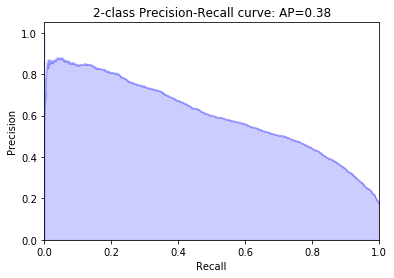

In [224]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, preds_proba[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### Отбор лучшего порога отсечения на основе F1-score

In [185]:
from sklearn.metrics import f1_score

In [240]:
from sklearn import metrics
metrics.auc(recall, precision)

0.6045807283710929

In [186]:
def f1sc(pr, rec):
    return 2 * (pr * rec)/(pr + rec)

In [187]:
f1sc_log = []
for pr, rec in zip(precision, recall):
    f1sc_log.append(f1sc(pr, rec))

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


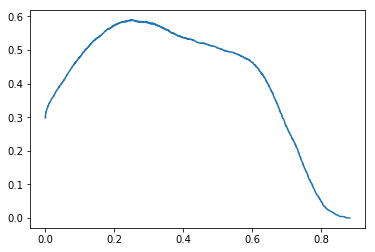

In [188]:
plt.plot(thresholds[:-1], f1sc_log[:-2])

In [189]:
# лучший трешхолд с точки зрения F1 меры
optim_thresh = thresholds[:-1][np.argmax(f1sc_log[:-2])]
optim_thresh

0.2495961675689291

Ищем число срабатываний

$$ recall = \frac{TP}{l_+} $$

$$ precision = \frac{TP}{TP + FP} $$

Число срабатываний: $ TP + FP $

Еще пару формул:
$$ TP = recall \cdot l_+ $$
$$ FP = (\frac{TP}{precision} - TP) $$

In [190]:
pr = precision[:-2][np.argmax(f1sc_log[:-2])]
rec = recall[:-2][np.argmax(f1sc_log[:-2])]

In [191]:
TP = rec * np.sum(y_test)
FP = (TP/pr) - TP
print("Число срабатываиний: {}".format(TP+FP))

Число срабатываиний: 6428.0


In [192]:
np.sum(preds_proba[:, 1] >= optim_thresh)

6428